In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import pandas as pd
import AA_Import_LCP_Functions as chase_lcc

# Data Import

In [2]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Random Forest

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def prepare_data_x(wt_dict, D132H_dict, window_size):
    wildtype_data = wt_dict[window_size]
    wildtype_label = np.zeros(len(wildtype_data))
    mutant_data = D132H_dict[window_size]
    mutant_label = np.ones(len(mutant_data))

    lcc_data = np.vstack((wildtype_data, mutant_data))
    label_data = np.hstack((wildtype_label, mutant_label))
    lcc_data, label_data = unison_shuffled_copies(lcc_data, label_data)
    lcc_data /= 100
    upper_training_limit = int(len(lcc_data) * 0.8)
    
    # Splitting the data into training and testing sets
    X_train, X_test = lcc_data[:upper_training_limit], lcc_data[upper_training_limit:]
    y_train, y_test = label_data[:upper_training_limit], label_data[upper_training_limit:]

    return X_train, X_test, y_train, y_test

In [4]:
# Directories for saving feature importances
default_dir = "RF_Default_HPs_Feature_Importance"
select_dir = "RF_Select_HPs_Feature_Importance"

# Create directories if they don't exist
if not os.path.exists(default_dir):
    os.makedirs(default_dir)
if not os.path.exists(select_dir):
    os.makedirs(select_dir)

# Initialize lists to store accuracies
rf_default_accuracies = []
rf_select_accuracies = []
window_sizes = range(2, 52)

for window_size in tqdm(window_sizes):
    X_train, X_test, y_train, y_test = prepare_data_x(wt_dict, D132H_dict, window_size)
    
    # Filename for saving feature importances
    filename = f"Feature_Importance_WS_{window_size}.csv"

    # Random Forest Classifier with default hyperparameters
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    rf_predictions = rf_clf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_predictions)
    rf_default_accuracies.append(rf_acc)

    # Save default model's feature importances
    default_path = os.path.join(default_dir, filename)
    if not os.path.exists(default_path):
        pd.DataFrame(rf_clf.feature_importances_).to_csv(default_path, index=False)
    else:
        print(f"Feature Importances for window size {window_size} already saved in default settings.")

    # Random Forest Classifier with selected hyperparameters
    rfs_clf = RandomForestClassifier(n_estimators=400, max_leaf_nodes=32, n_jobs=-1)
    rfs_clf.fit(X_train, y_train)
    rfs_predictions = rfs_clf.predict(X_test)
    rfs_acc = accuracy_score(y_test, rfs_predictions)
    rf_select_accuracies.append(rfs_acc)

    # Save select model's feature importances
    select_path = os.path.join(select_dir, filename)
    if not os.path.exists(select_path):
        pd.DataFrame(rfs_clf.feature_importances_).to_csv(select_path, index=False)
    else:
        print(f"Feature Importances for window size {window_size} already saved in select settings.")

100%|███████████████████████████████████████████| 50/50 [53:18<00:00, 63.98s/it]


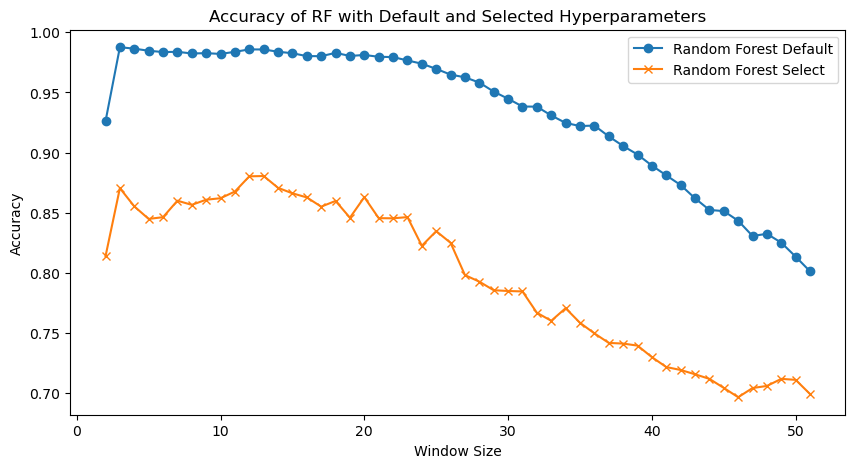

In [5]:
# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(window_sizes, rf_default_accuracies, label='Random Forest Default', marker='o')
plt.plot(window_sizes, rf_select_accuracies, label='Random Forest Select', marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy of RF with Default and Selected Hyperparameters')
plt.legend()
plt.show()

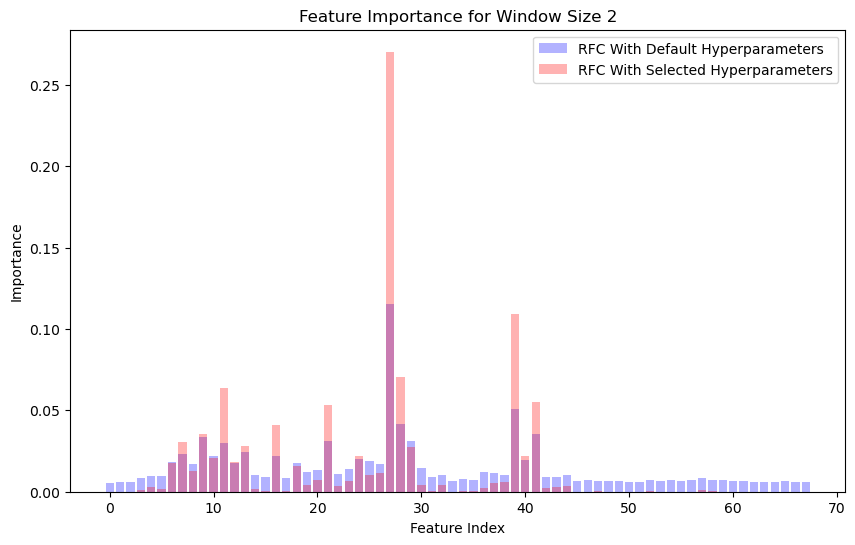

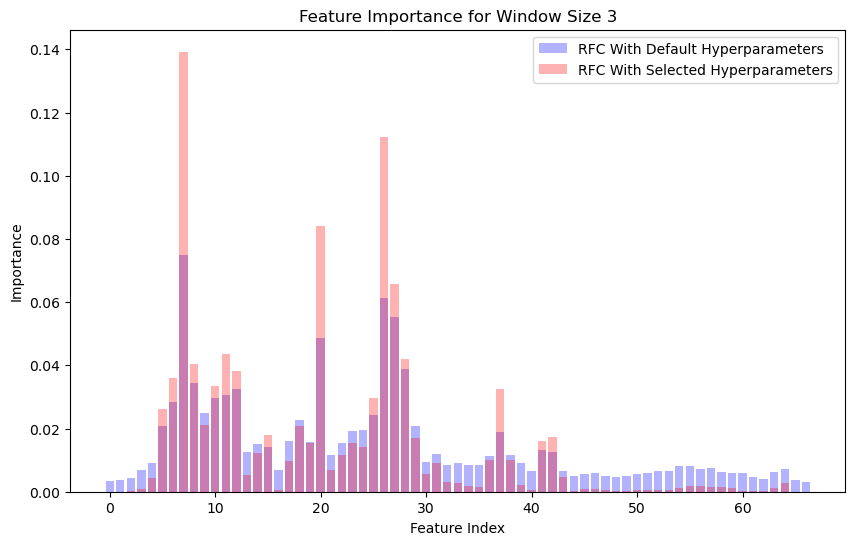

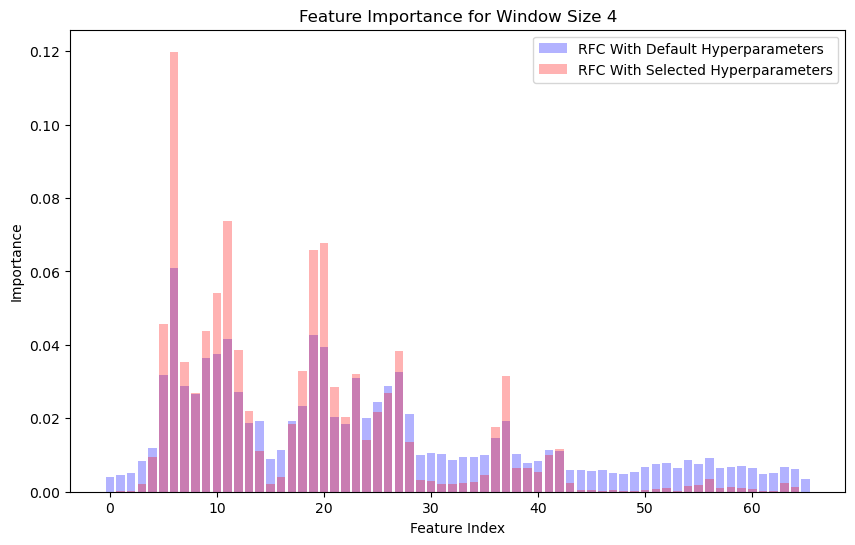

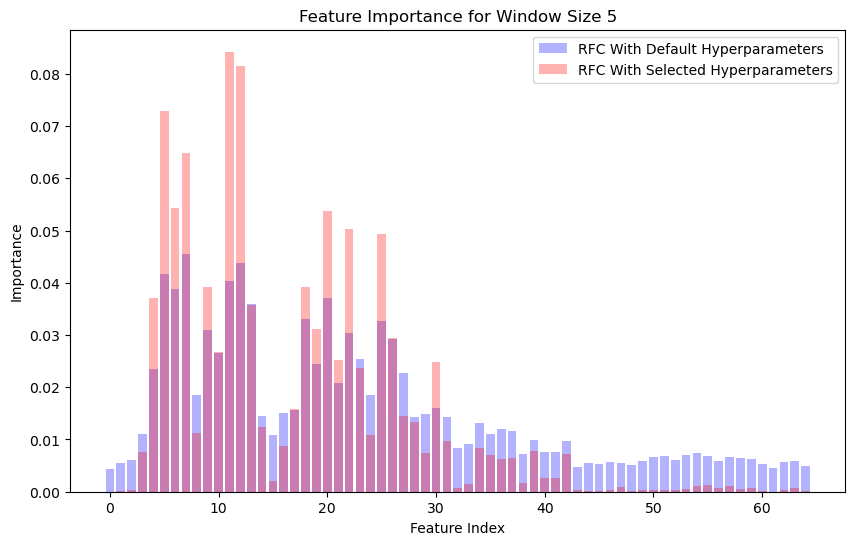

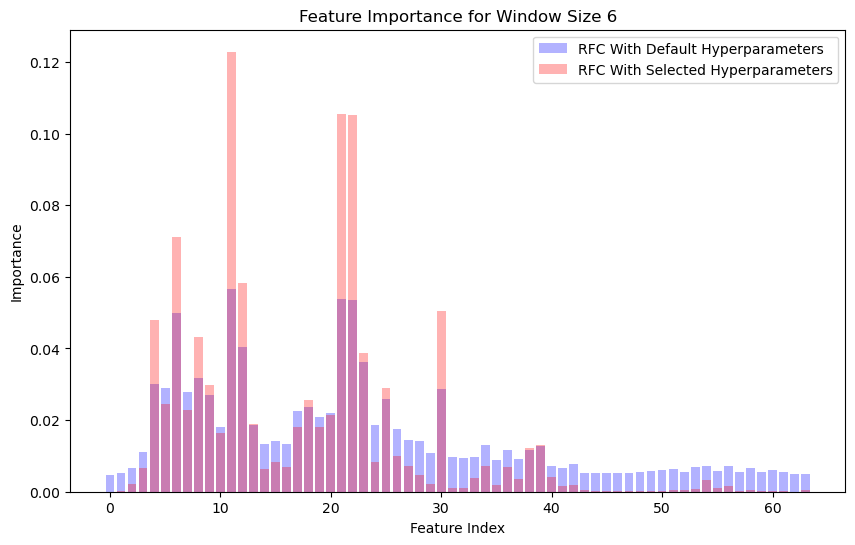

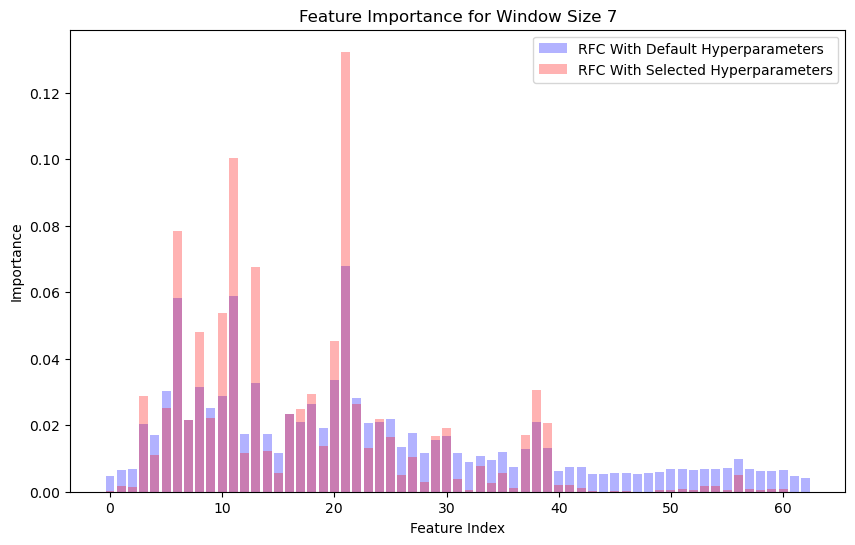

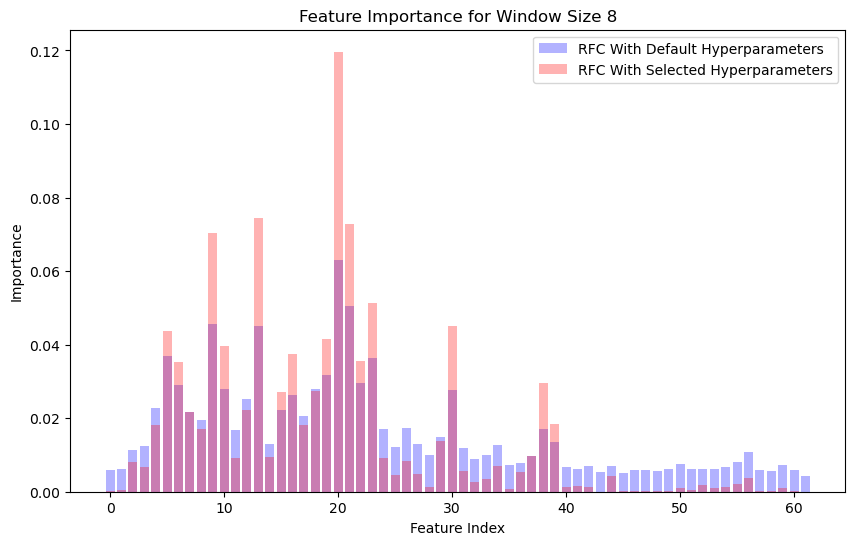

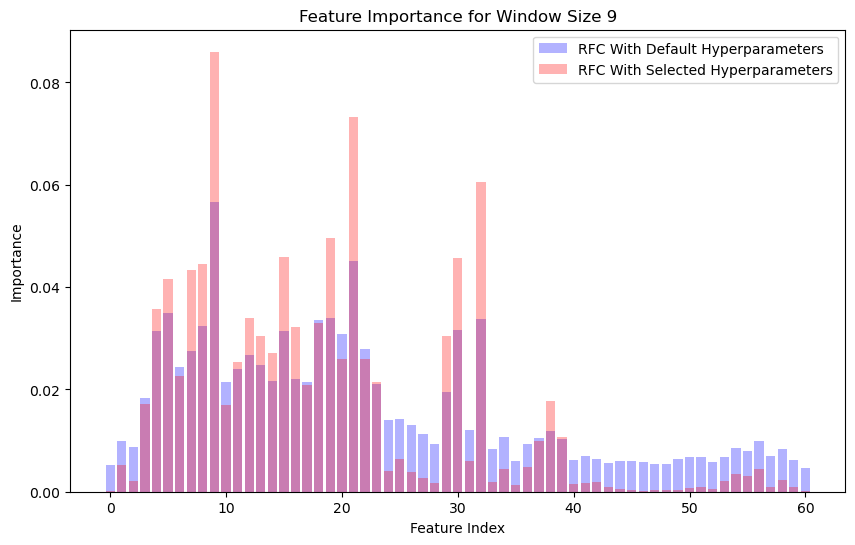

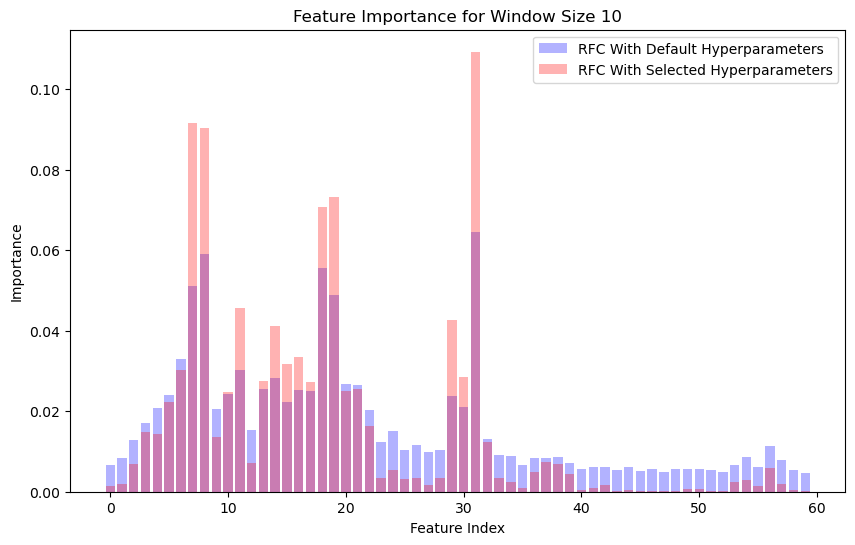

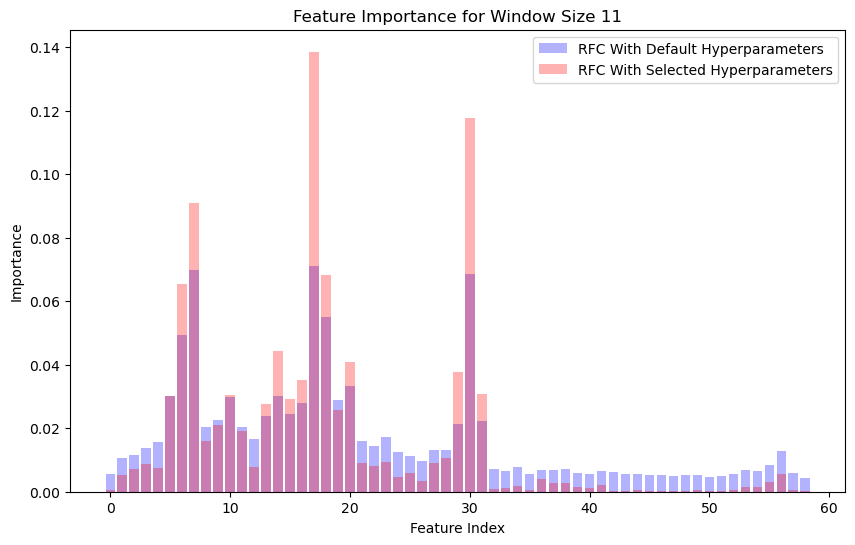

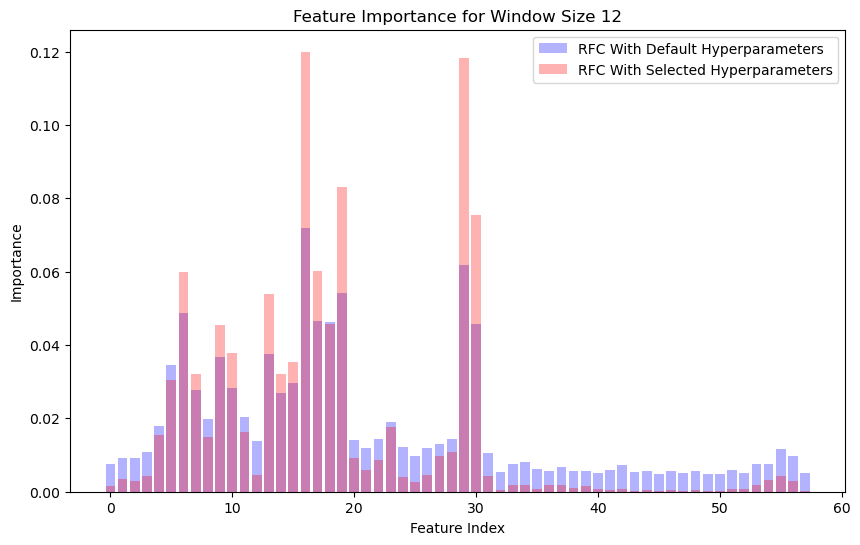

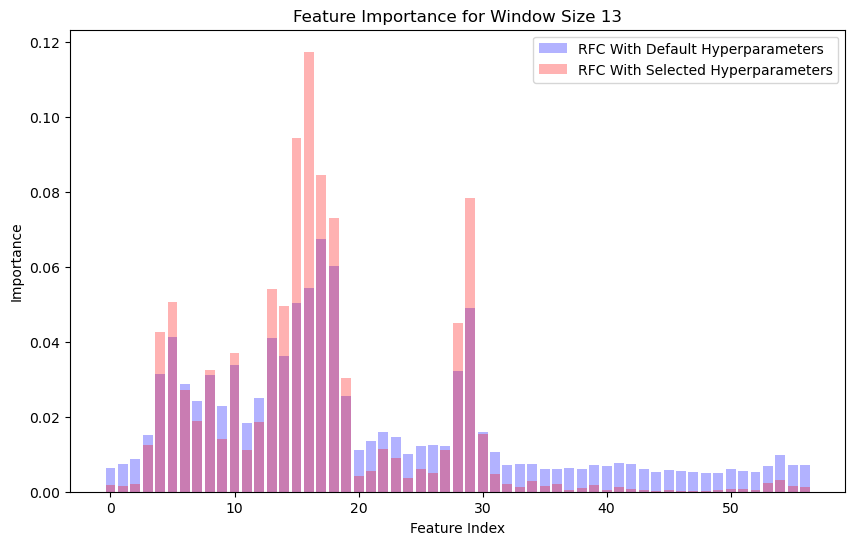

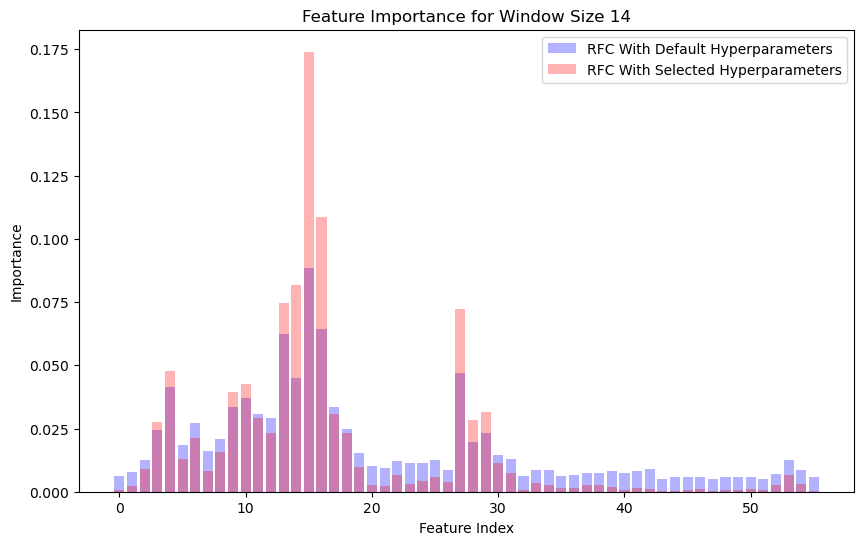

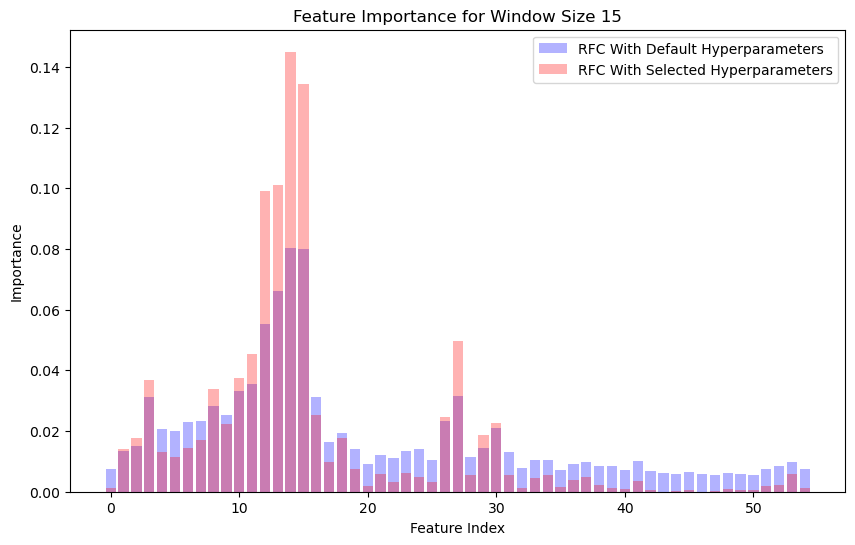

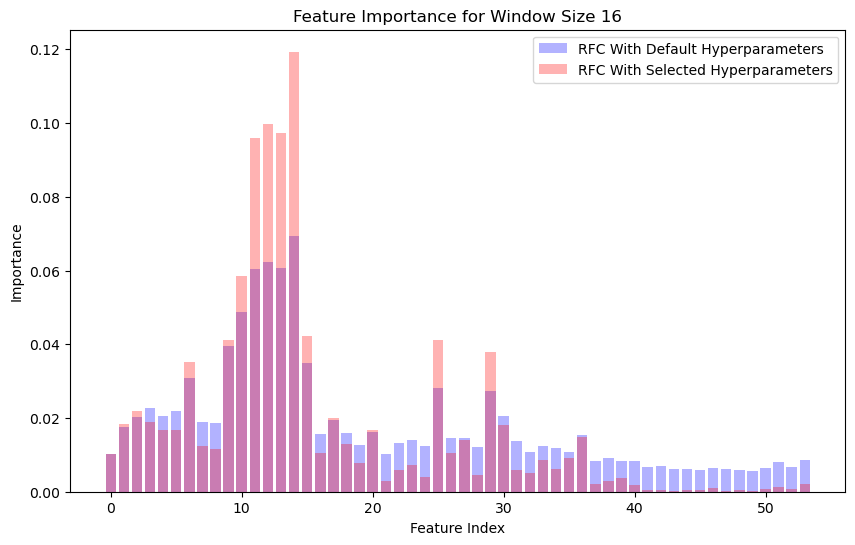

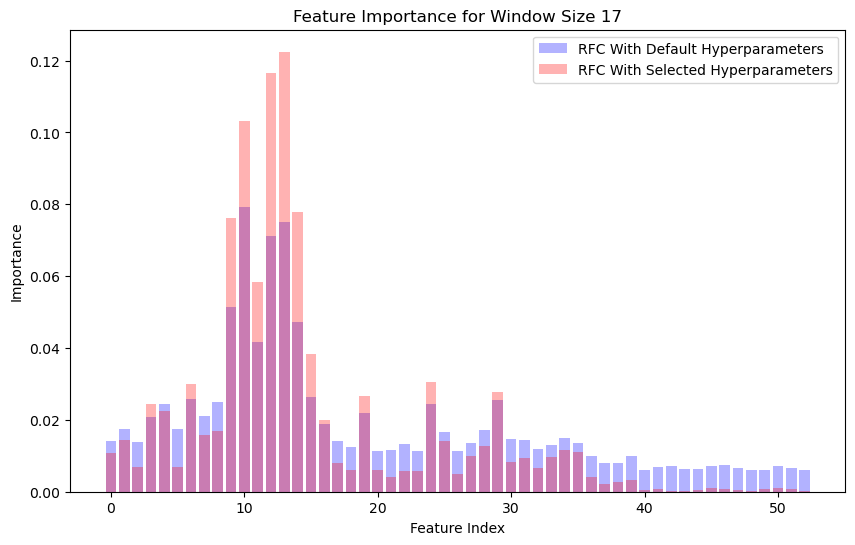

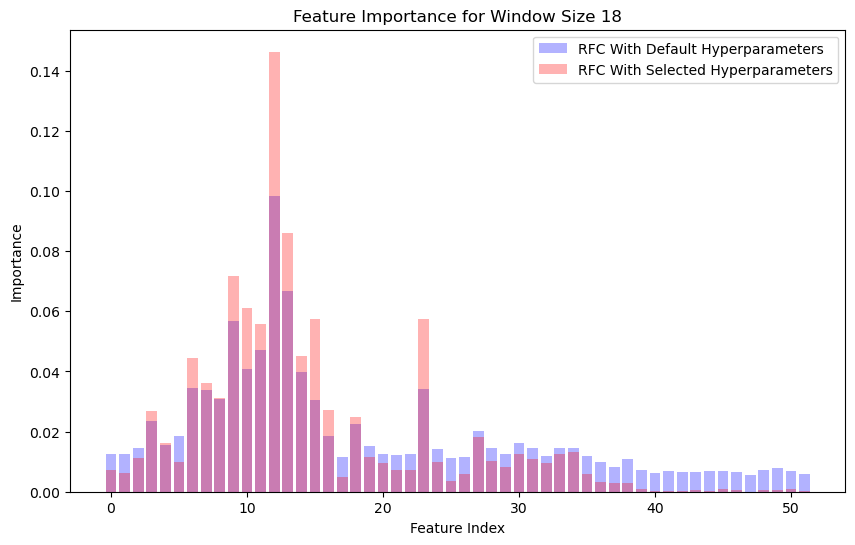

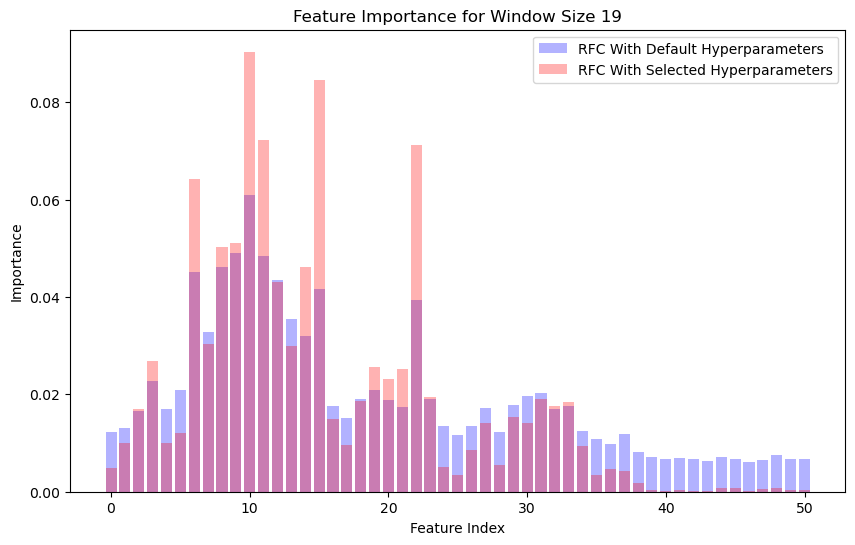

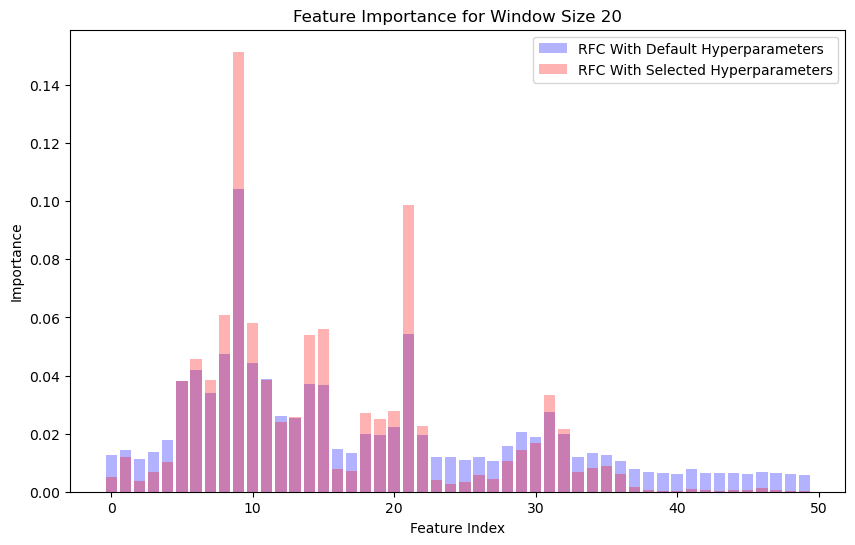

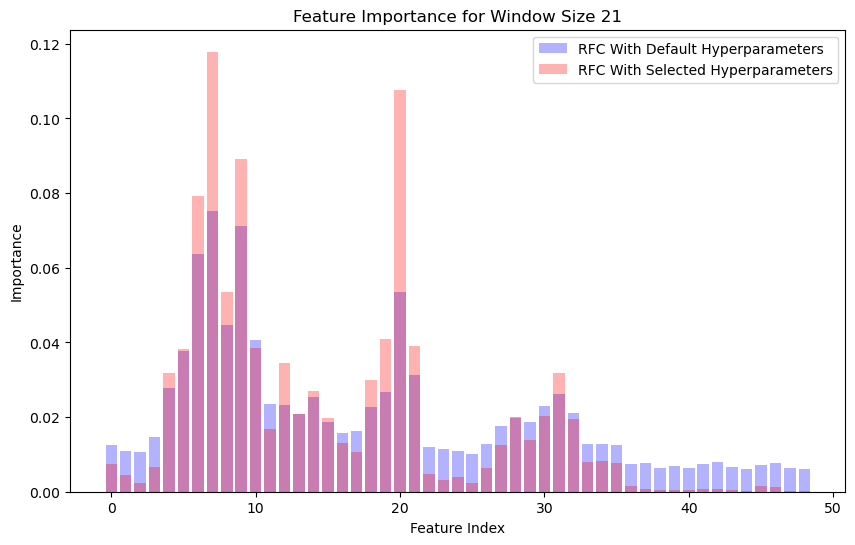

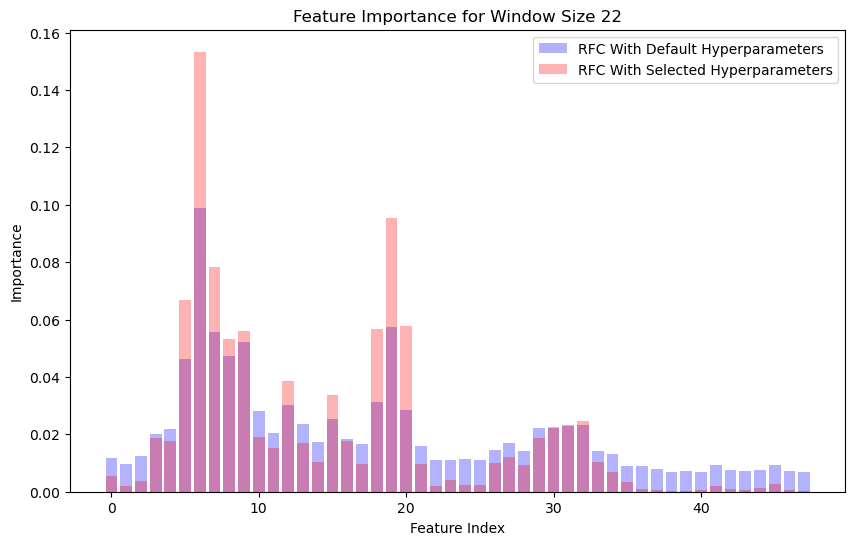

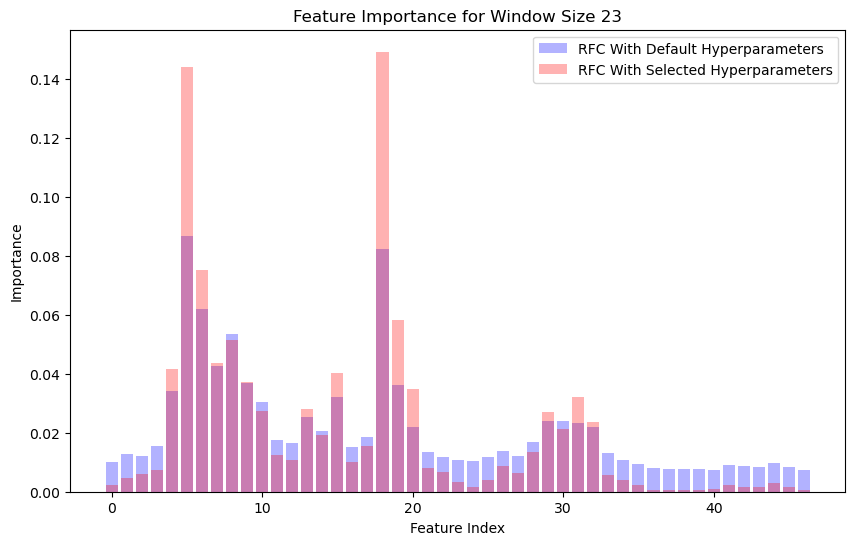

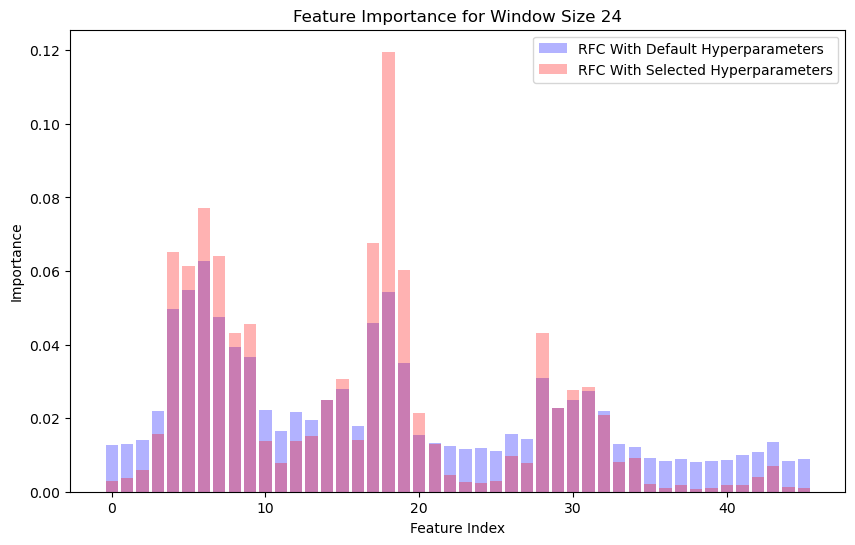

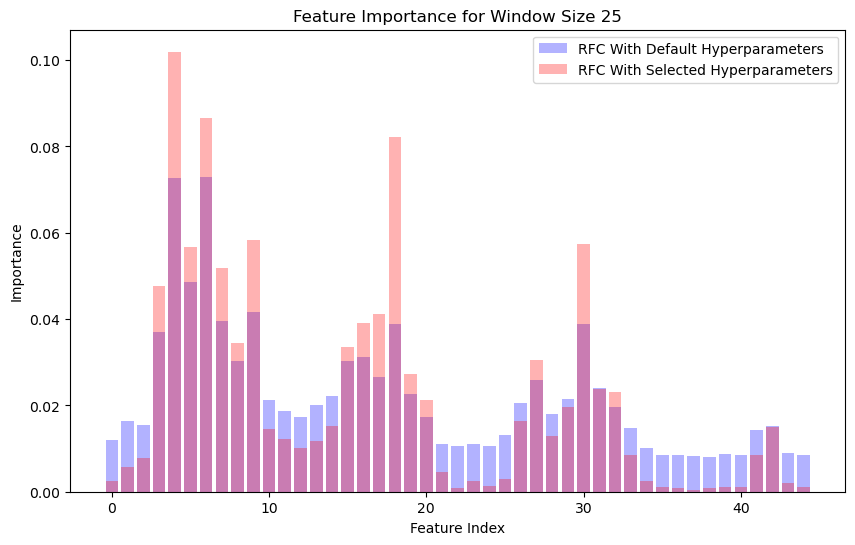

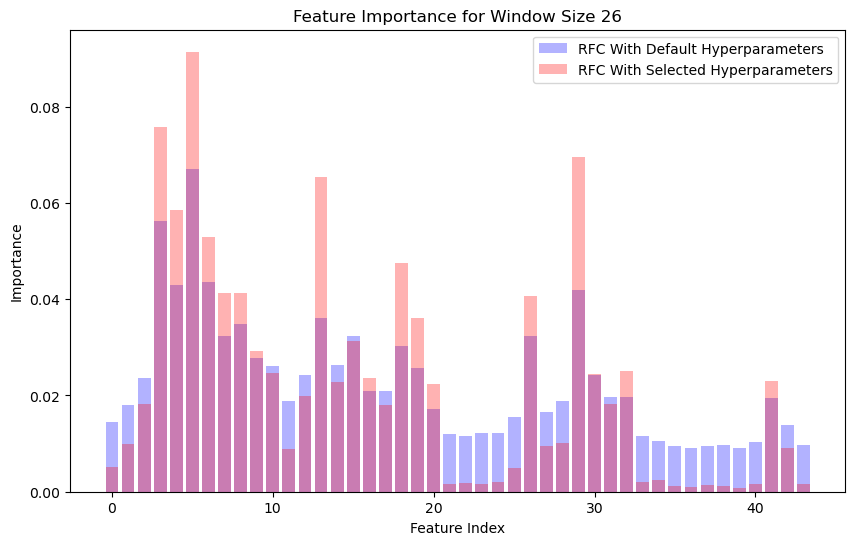

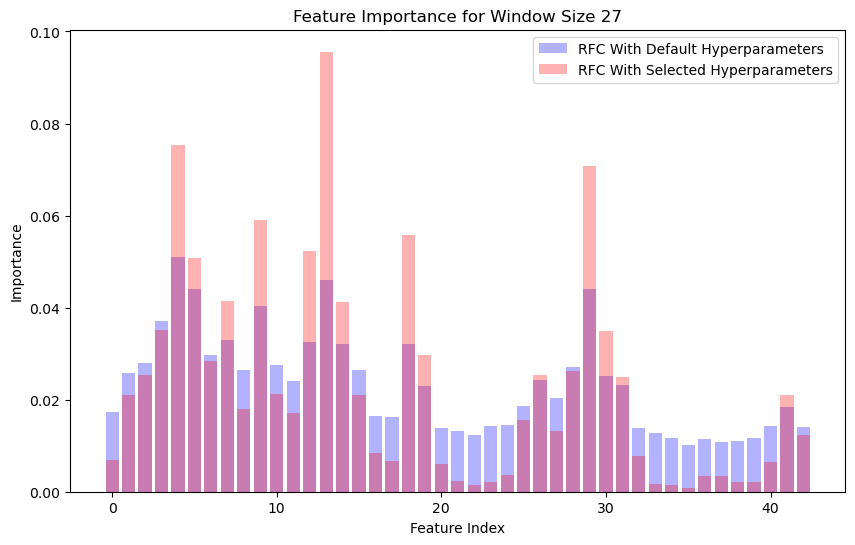

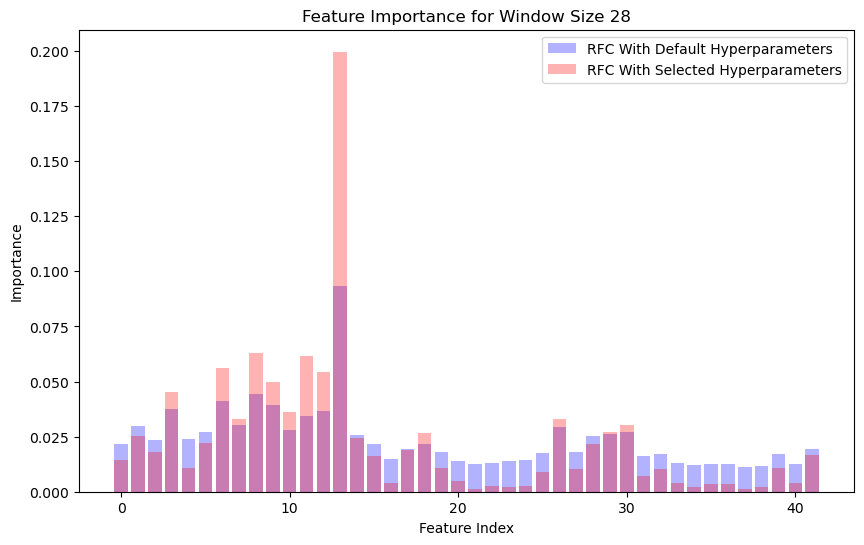

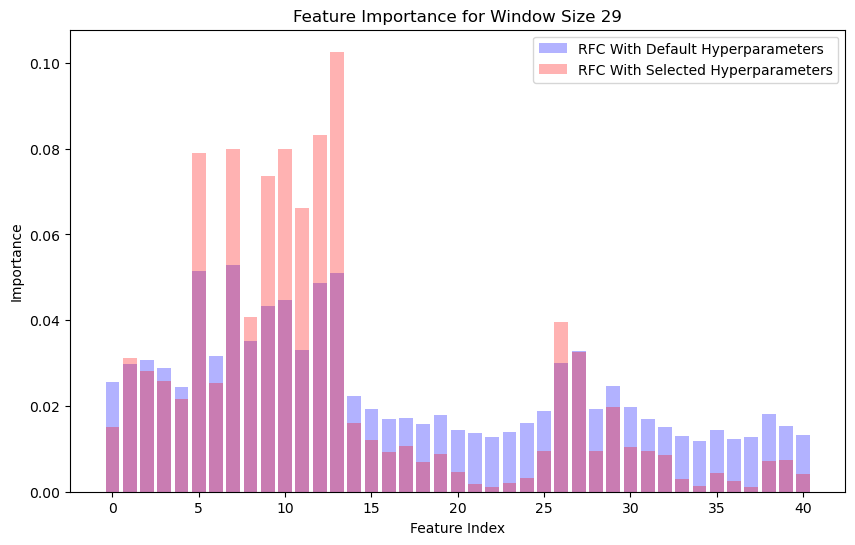

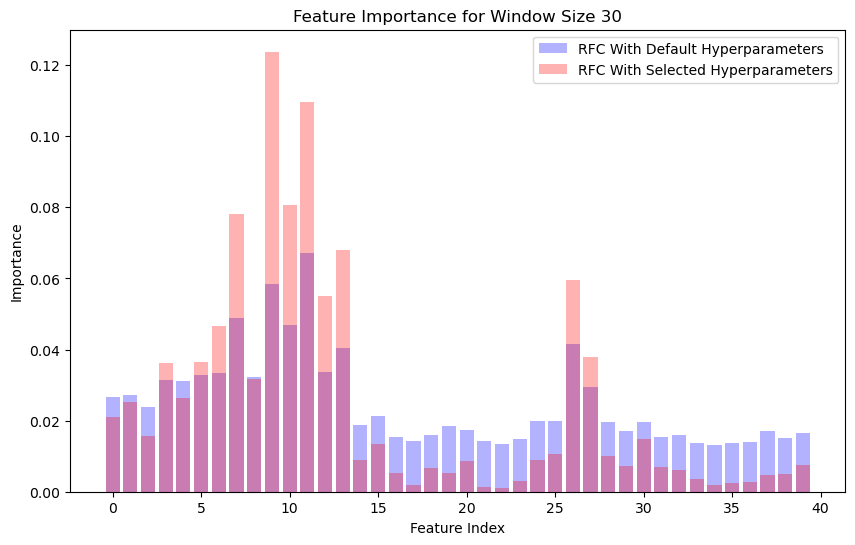

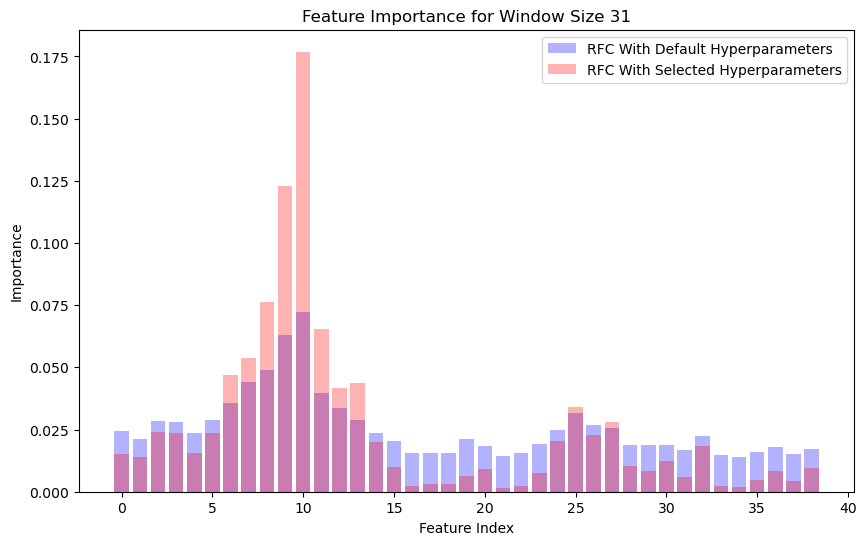

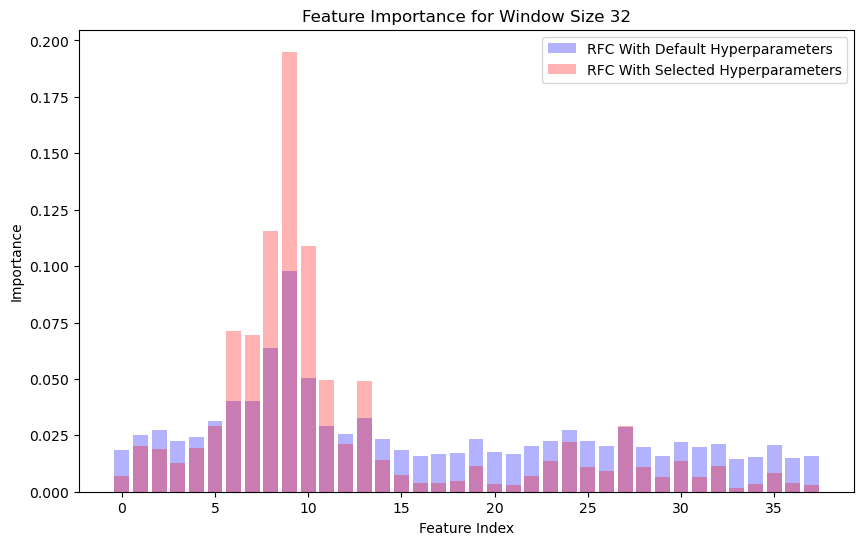

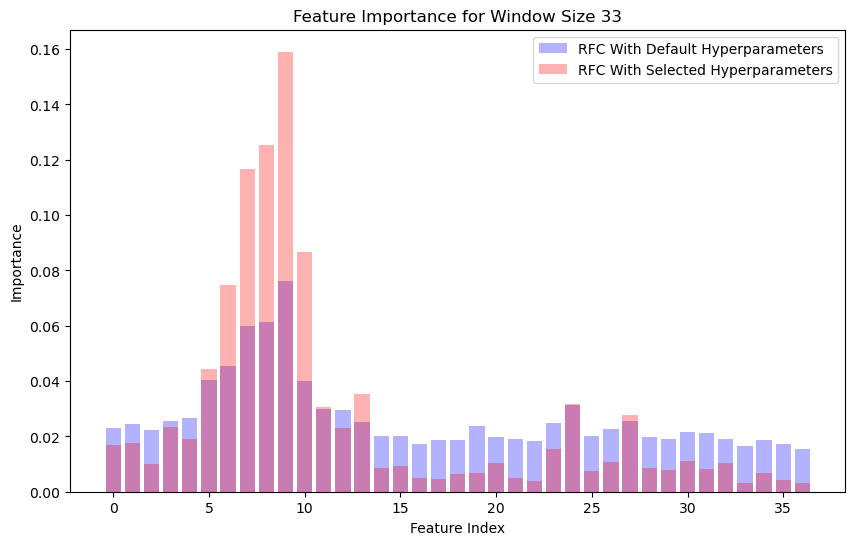

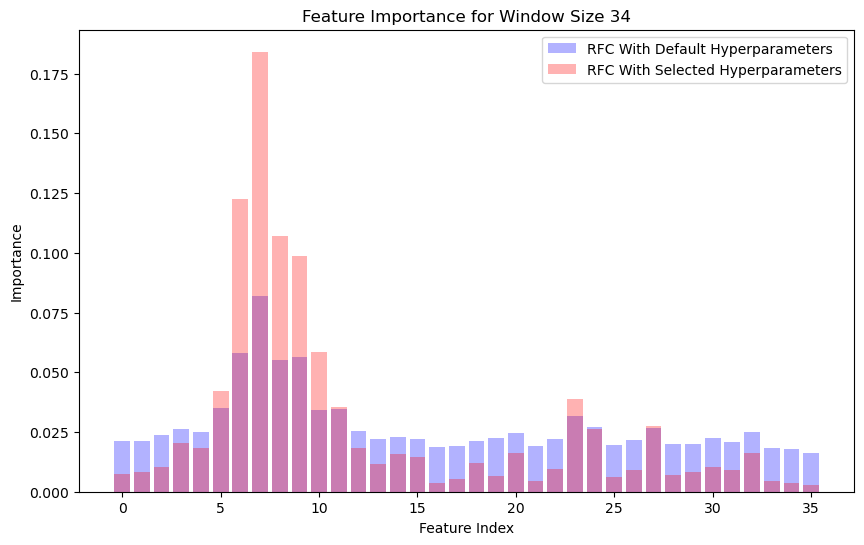

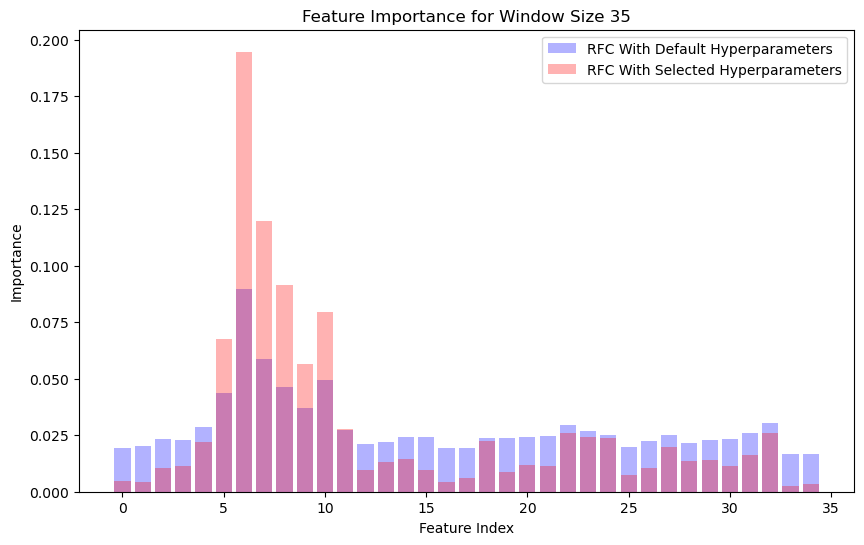

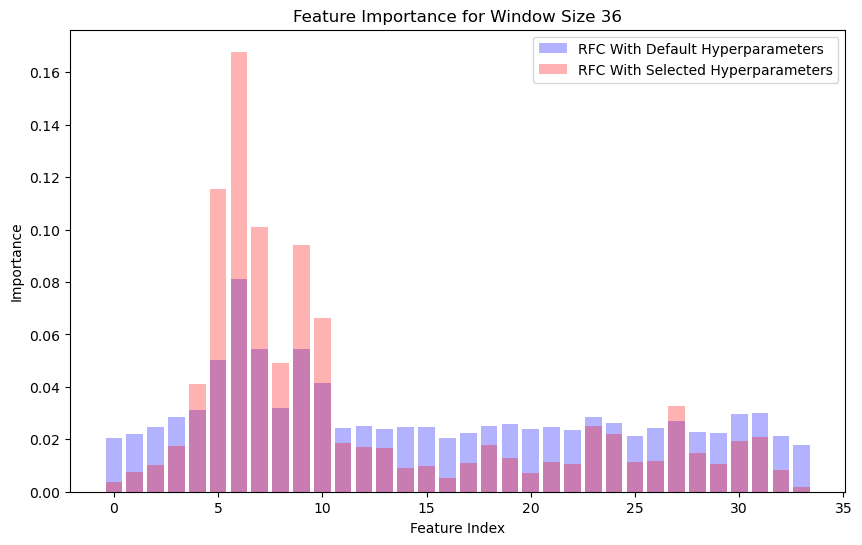

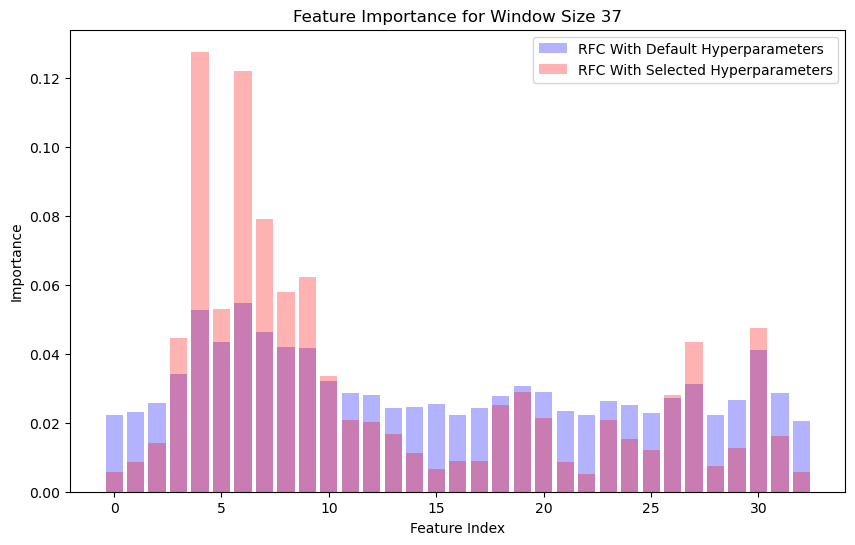

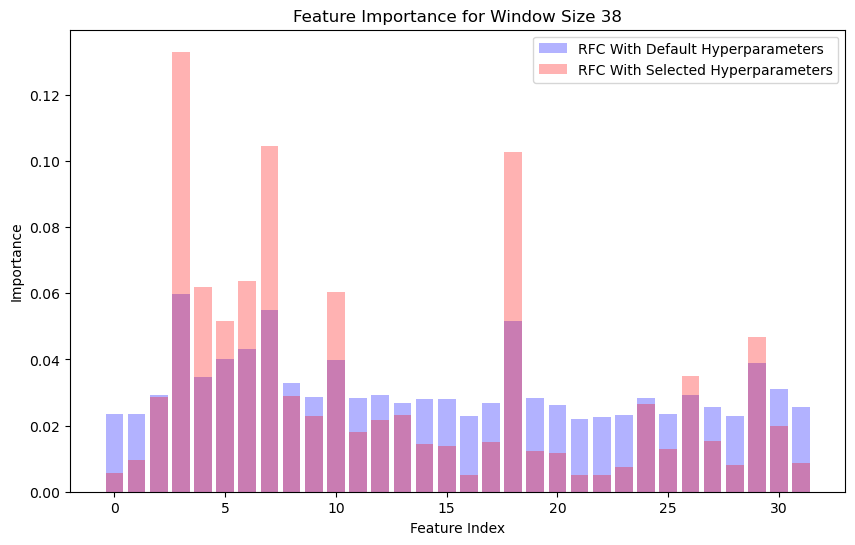

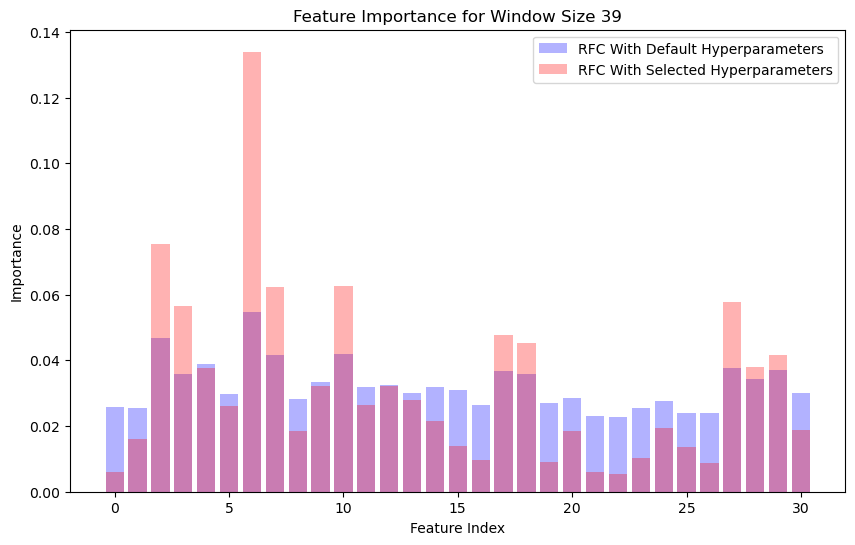

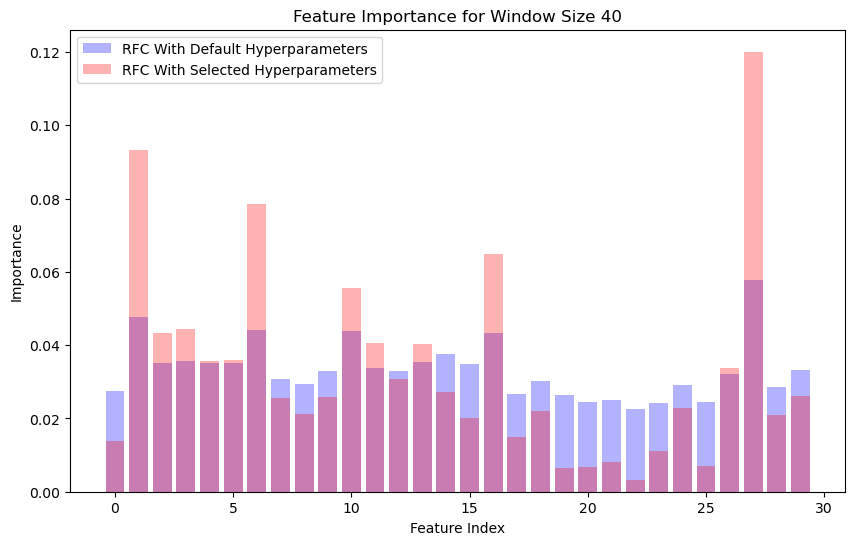

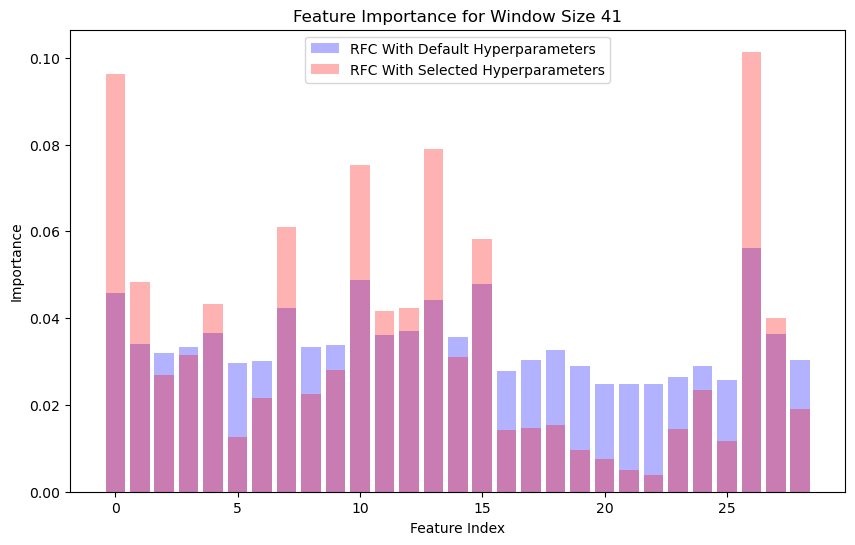

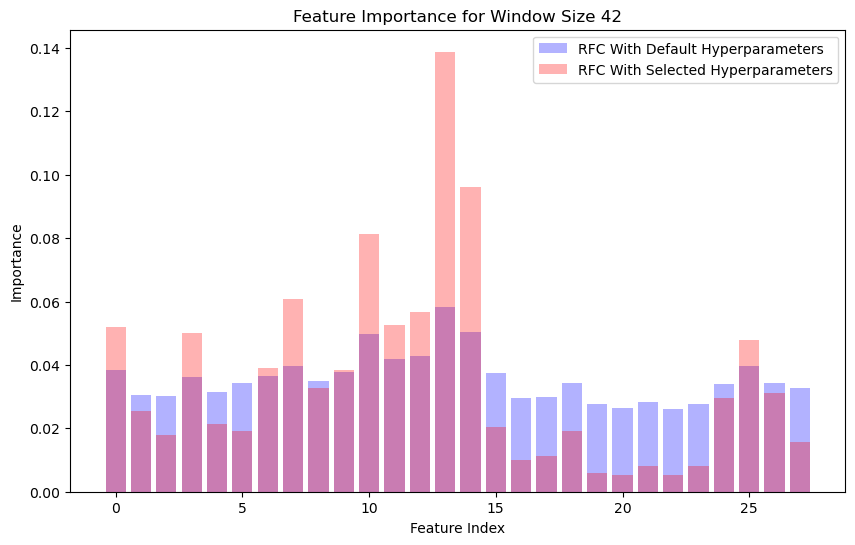

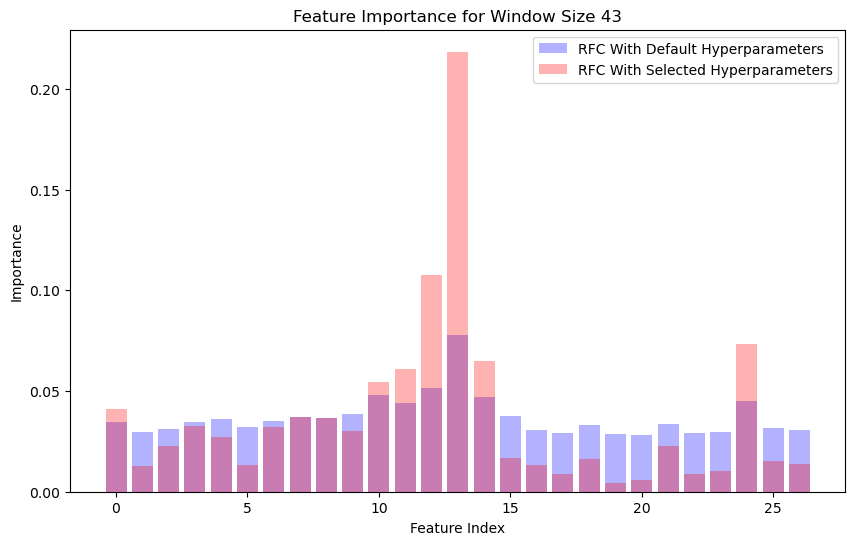

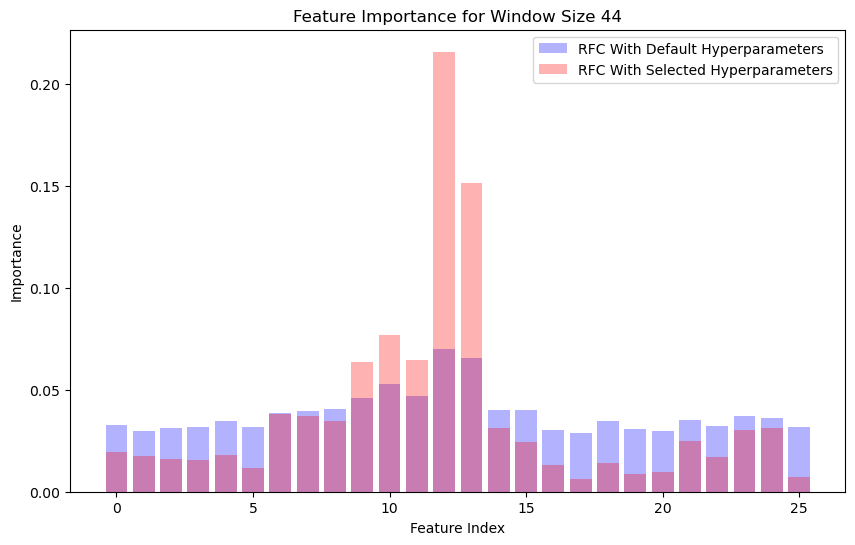

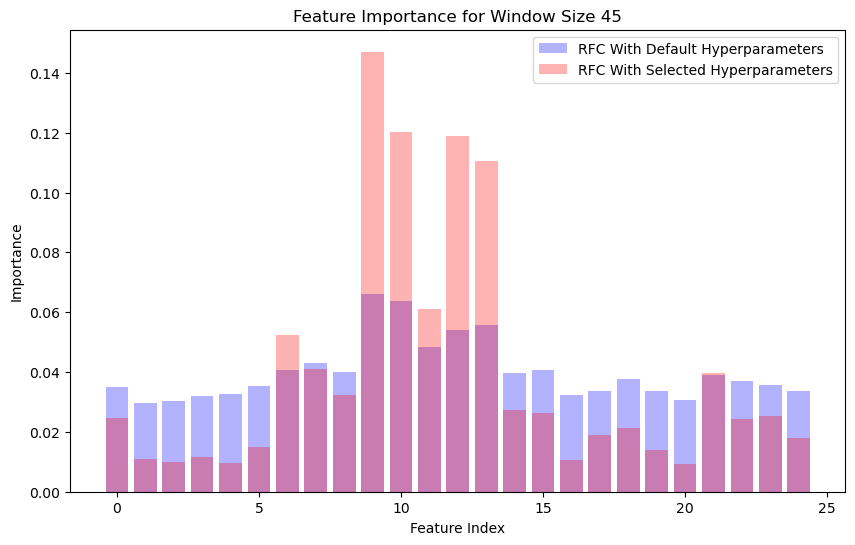

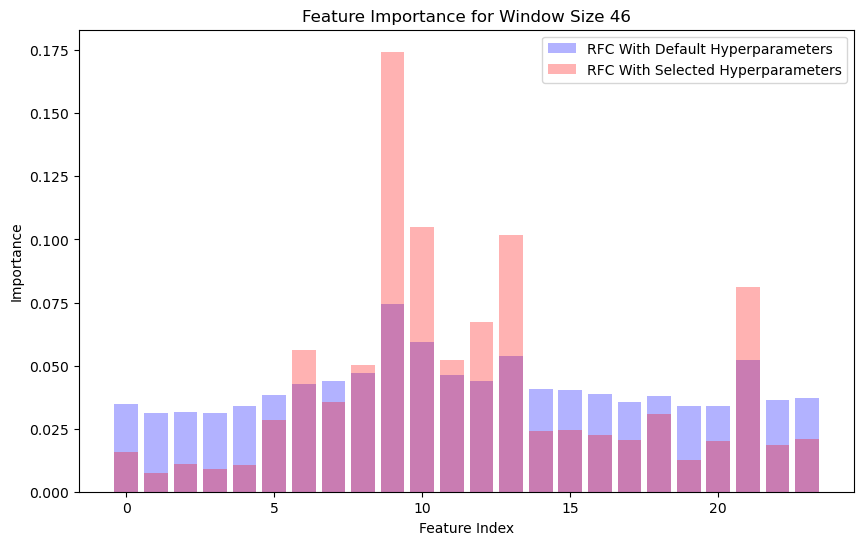

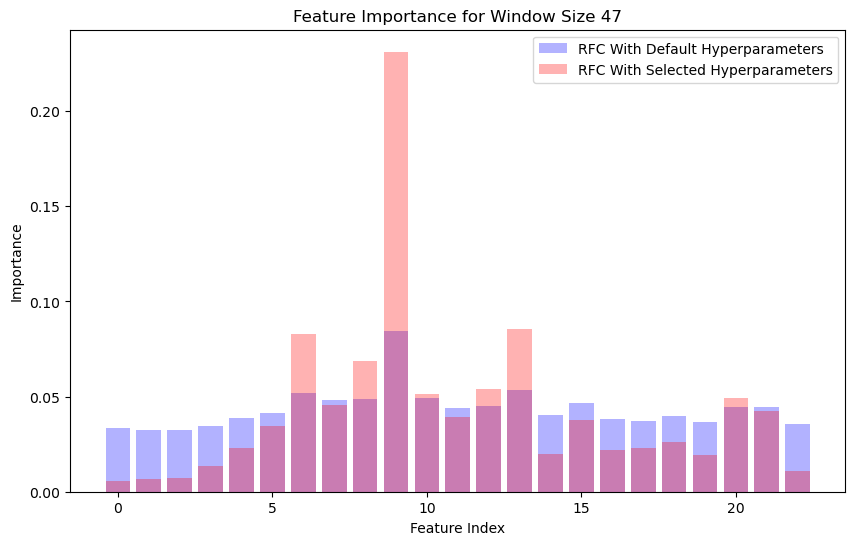

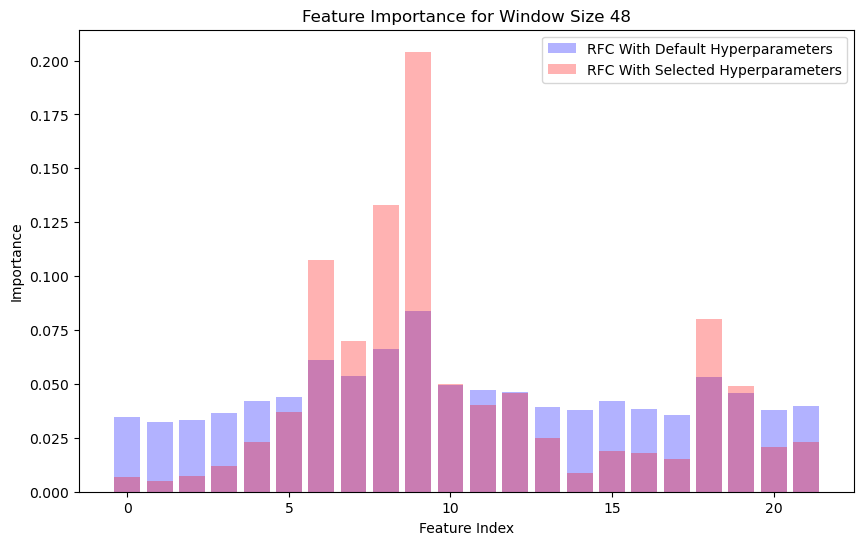

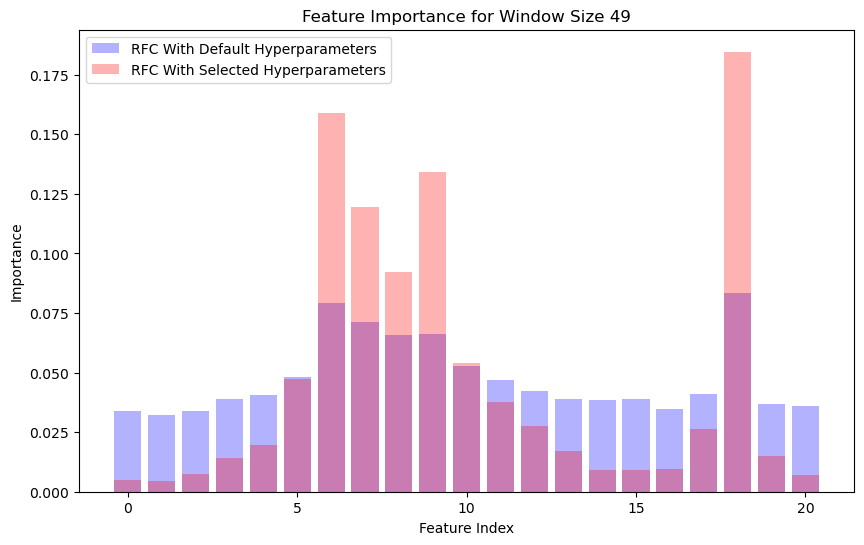

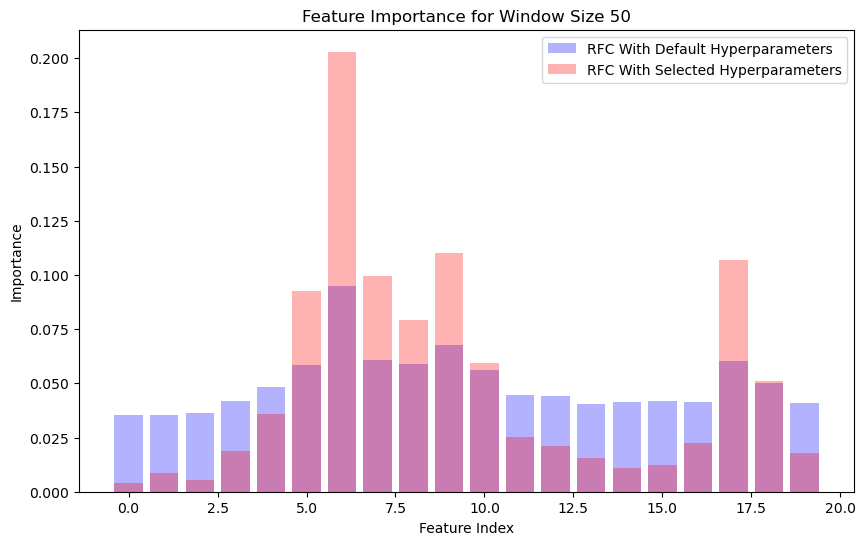

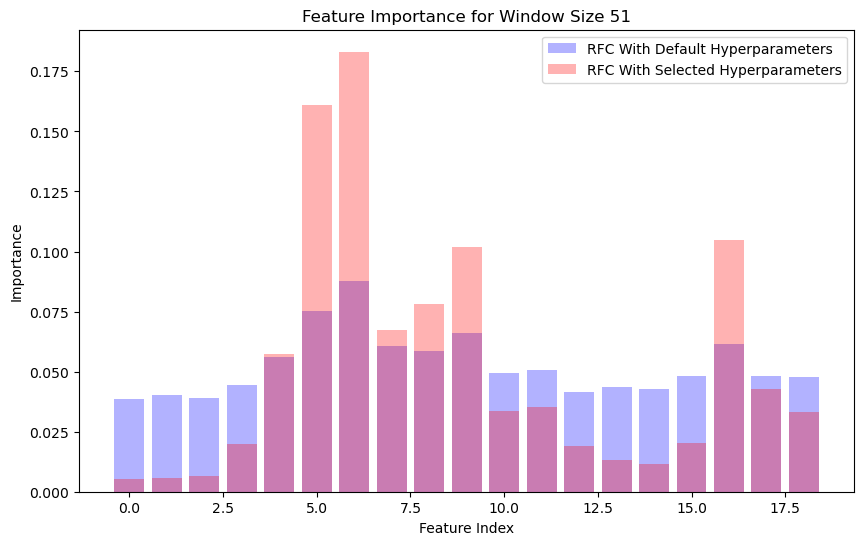

In [6]:
default_dir = "RF_Default_HPs_Feature_Importance"
select_dir = "RF_Select_HPs_Feature_Importance"

window_sizes = range(2, 52)

for window_size in window_sizes:
    # Filename for the current window size
    filename = f"Feature_Importance_WS_{window_size}.csv"

    # Paths to the default and select feature importances
    default_path = os.path.join(default_dir, filename)
    select_path = os.path.join(select_dir, filename)

    # Read the feature importances
    default_importances = pd.read_csv(default_path)
    select_importances = pd.read_csv(select_path)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(default_importances)), default_importances.iloc[:, 0], alpha=0.3, color='blue', label='RFC With Default Hyperparameters')
    plt.bar(range(len(select_importances)), select_importances.iloc[:, 0], alpha=0.3, color='red', label='RFC With Selected Hyperparameters')
    plt.title(f'Feature Importance for Window Size {window_size}')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.legend()
    plt.show()